In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# Load data from Excel files
books_df = pd.read_excel("../Data/Lektury_szkolne_baza.xlsx")
promotions_df = pd.read_excel("../Data/promocje_księgarnie.xlsx")

# Normalize column names (remove spaces, lowercase)
books_df.columns = books_df.columns.str.strip().str.lower()
promotions_df.columns = promotions_df.columns.str.strip().str.lower()

# Find the column with formula (e.g., "formuła_promo")
formula_col = next((col for col in promotions_df.columns if 'formuła' in col), None)
if formula_col is None:
    raise ValueError("Promotion formula column not found.")


In [2]:
# Function to calculate total price with shipping and promotion
def calculate_total_price(store_id, books, promo_dict):
    prices = list(books['cena książki'])
    shipping_cost = books['cena dostawy'].iloc[0]
    total_price = sum(prices)

    # Apply promotion if available
    formula = promo_dict.get(store_id)
    if pd.notna(formula):
        local_vars = {'prices': sorted(prices), 'total_price': total_price, 'shipping_cost': shipping_cost}
        try:
            exec(formula, {}, local_vars)
            total_price = local_vars.get('total_price', total_price)
            shipping_cost = local_vars.get('shipping_cost', shipping_cost)
        except Exception as e:
            print(f"⚠️ Promotion error for store {store_id}: {e}")
    
    return total_price + shipping_cost


In [3]:
# Main function to compare purchase options
def compare_purchase_options(wishlist, test_name="Test"):
    print(f"\n📚 {test_name} - Books to buy: {wishlist}")
    
    wishlist_df = books_df[books_df['nazwa książki'].isin(wishlist)].copy()
    grouped_by_store = wishlist_df.groupby('id księgarni')

    # Map promotions
    promo_dict = {}
    for _, row in promotions_df.iterrows():
        promo_dict[row['id_księgarni']] = row[formula_col]

    # Option 1 – Buy all in one store
    single_store_options = {}
    for store_id, books in grouped_by_store:
        if set(wishlist).issubset(set(books['nazwa książki'])):
            total = calculate_total_price(store_id, books[books['nazwa książki'].isin(wishlist)], promo_dict)
            single_store_options[store_id] = total

    # Option 2 – Cheapest per book
    cheapest_books = []
    for title in wishlist:
        book_options = wishlist_df[wishlist_df['nazwa książki'] == title]
        if book_options.empty:
            print(f"⚠️ Book not found: {title}")
            continue
        cheapest = book_options.loc[book_options['cena książki'].idxmin()]
        cheapest_books.append(cheapest)

    cheapest_df = pd.DataFrame(cheapest_books)
    multi_store_total = 0
    for store_id, group in cheapest_df.groupby('id księgarni'):
        total = calculate_total_price(store_id, group, promo_dict)
        multi_store_total += total

    # Display result
    print("\n💰 Option 1: One bookstore")
    for store, price in single_store_options.items():
        print(f"Bookstore {store}: {price:.2f} zł")

    print(f"\n💰 Option 2: Cheapest per book: {multi_store_total:.2f} zł")

    # Return values for plotting
    best_single = min(single_store_options.values()) if single_store_options else None
    return (test_name, best_single, multi_store_total)


In [4]:
test_cases = [
    ("Test 1 – School Basics", [
        "Opowieści z Narnii: Lew, czarownica i stara szafa",
        "W pustyni i w puszczy",
        "Akademia pana Kleksa",
        "Chłopcy z Placu Broni"
    ]),
    ("Test 2 – Extended Set", [
        "Mały Książę", "Balladyna", "Pan Tadeusz", "Latarnik"
    ]),
    ("Test 3 – Full Class Set", [
        "Syzyfowe prace", "Zemsta", "Katarynka", "Kamienie na szaniec"
    ]),
    ("Test 4 – Cheapest Test", [
        "Balladyna", "Latarnik"
    ]),
    ("Test 5 – Max Value Test", [
        "Opowieści z Narnii: Lew, czarownica i stara szafa", "Pan Tadeusz",
        "Akademia pana Kleksa", "Zemsta", "Syzyfowe prace"
    ])
]

results = []
for test_name, book_list in test_cases:
    result = compare_purchase_options(book_list, test_name)
    results.append(result)



📚 Test 1 – School Basics - Books to buy: ['Opowieści z Narnii: Lew, czarownica i stara szafa', 'W pustyni i w puszczy', 'Akademia pana Kleksa', 'Chłopcy z Placu Broni']

💰 Option 1: One bookstore
Bookstore 1: 107.00 zł
Bookstore 2: 115.50 zł
Bookstore 3: 96.00 zł
Bookstore 4: 98.20 zł
Bookstore 5: 70.00 zł

💰 Option 2: Cheapest per book: 113.50 zł

📚 Test 2 – Extended Set - Books to buy: ['Mały Książę', 'Balladyna', 'Pan Tadeusz', 'Latarnik']

💰 Option 1: One bookstore
Bookstore 1: 110.00 zł
Bookstore 2: 107.00 zł
Bookstore 3: 80.50 zł
Bookstore 4: 105.85 zł
Bookstore 5: 63.50 zł

💰 Option 2: Cheapest per book: 126.50 zł

📚 Test 3 – Full Class Set - Books to buy: ['Syzyfowe prace', 'Zemsta', 'Katarynka', 'Kamienie na szaniec']

💰 Option 1: One bookstore
Bookstore 1: 108.50 zł
Bookstore 2: 118.50 zł
Bookstore 3: 90.50 zł
Bookstore 4: 107.65 zł
Bookstore 5: 69.00 zł

💰 Option 2: Cheapest per book: 143.50 zł

📚 Test 4 – Cheapest Test - Books to buy: ['Balladyna', 'Latarnik']

💰 Option 1:

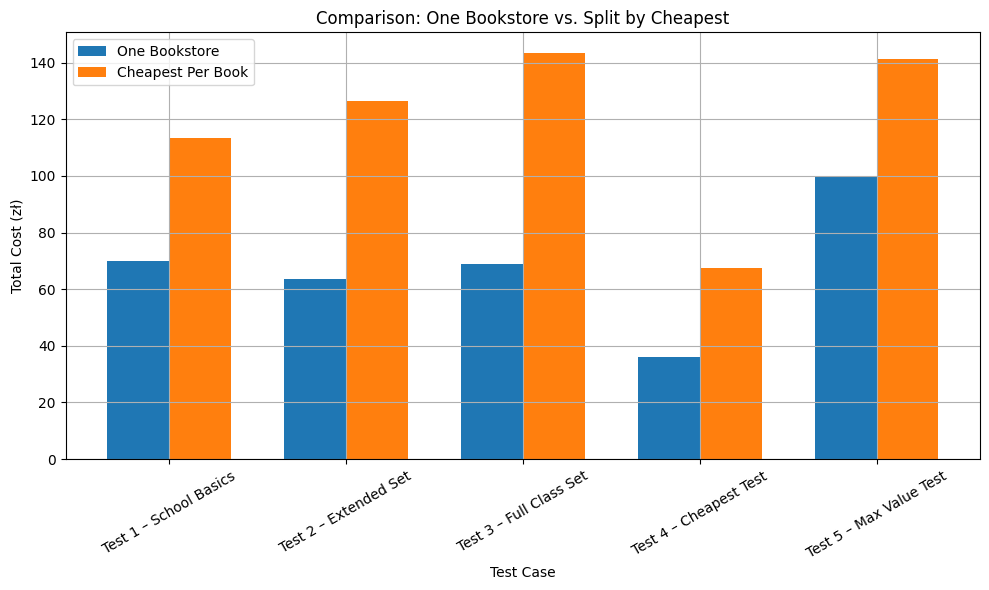

In [5]:
# Prepare bar chart from results
labels = [r[0] for r in results]
single_prices = [r[1] if r[1] is not None else 0 for r in results]
multi_prices = [r[2] for r in results]

x = range(len(labels))
width = 0.35

plt.figure(figsize=(10, 6))
plt.bar(x, single_prices, width, label="One Bookstore")
plt.bar([i + width for i in x], multi_prices, width, label="Cheapest Per Book")

plt.xlabel("Test Case")
plt.ylabel("Total Cost (zł)")
plt.title("Comparison: One Bookstore vs. Split by Cheapest")
plt.xticks([i + width / 2 for i in x], labels, rotation=30)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
